# MDP's

## Come up with 2 MDP problems
* Evironment guidlines
    * MDP 1 should have a small number of states
    * MDP 2 should have a large number of states (perhaps thousands)
        * https://gymnasium.farama.org/tutorials/environment_creation/
* Resources
    * https://gymnasium.farama.org/

## Part 1: Solve each MDP using value iteration
    * http://www.incompleteideas.net/sutton/book/first/4/node5.html
    

## Part 2: Solve each MDP using policy iteration
    * http://www.incompleteideas.net/sutton/book/first/4/node4.html

## Part 3: Solve each MDP using a RL algorithm 

**Analysis**
* problem introductions
    * Come up with two interesting MDPs
    * Explain why they are interesting.
    * it will be worthwhile if your MDPs are inspired by some 
      process you are interested in or are familiar with
    * It's ok to keep it somewhat simple.
    * no more than one of the MDPs you choose should be a so-called grid world problem
* part 1 and 2
    * How many iterations does it take to converge?
    * Which one converges faster?
    * Why might the faster converge that way?
    * How do you define convergence?
    * Do the converge to the same answers?
    * Was the number of states a contributor to performance differences?
        * Hypothesis: Larger take longer to converge
* part 3
    * How does it perform compared to part 1 and 2
        * Consider how part 1 and 2 know the rewards, model, etc
    * What exploration strategies did you choose?
        * Compare different strategies and describe their performance

* Resources
    * [http://www.incompleteideas.net/sutton/book/first/4/node1.html] The term ``Dynamic Programming" (DP) refers to a collection of algorithms that can be used to compute optimal policies given a perfect model of the environment as a Markov decision process (MDP). Classical DP algorithms are of limited utility in reinforcement learning both because of their assumption of a perfect model and because of their great computational expense, but they are still very important theoretically. DP provides an essential foundation for the understanding of the methods presented in the rest of this book. In fact, all of these methods can be viewed as attempts to achieve much the same effect as DP, only with less computation and without assuming a perfect model of the environment.

In [6]:
import gymnasium
from matplotlib import pyplot as plt

In [7]:
# MDP 1 (8x8), is_slippery=True (more interesting)
env = gymnasium.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")

In [8]:
observation, info = env.reset()

In [127]:
from time import sleep

In [10]:
env.unwrapped.s = 5

In [30]:
env.unwrapped.s=1  # This sets the env starting point

In [29]:
a = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(a)
print(observation, reward, terminated, truncated, info)
if terminated or truncated:
    observation, info = env.reset()
    print(observation, info)

1 0.0 False False {'prob': 0.3333333333333333}


In [ ]:
# TODO Create transition matrix P, row index = s, column index = s'
# Initialize P[j][a][k] to 0's
# Intialize R[j][a][k] to 0's
# For j in env shape
# For a in action space
# repeat n times where n is arbitrary number of samples
# env.s=j
# k,r=env.step(a)
# if not active, break inner most loop and move to next action
# P[j][a][k]+=1/n
# R[j][a][k]=r (rewards will never change for s,s',a combination)

In [1]:
import numpy as np

In [754]:
from typing import Callable
from joblib import Parallel, delayed
from multiprocessing import cpu_count


# def par_step(env_class, env_kwargs, s, set_s: Callable):
#     env = env_class(**env_kwargs)
#     env.reset()
#     is_state = set_s(env, s)
#     if not is_state:
#         return None # TODO May need to adapt strategy for non-states
#     k, r, terminated, truncated, _ = env.step(a)
#     return k, r

def get_P_and_R(env, n_states, sample_size, set_s: Callable):
    shape = (n_states, env.action_space.n, n_states) 
    # Initialize P and R to 0's
    P = np.zeros(shape=shape, dtype=np.float32)
    R = np.zeros(shape=shape, dtype=np.float32)
    for j in range(n_states):
        for a in range(env.action_space.n):
            for _ in range(sample_size):
                # Setup environment_
                env.reset()
                is_state = set_s(env, j)
                if not is_state:
                    break
                # Take the action
                k, r, terminated, truncated, _ = env.step(a)
                # Update R
                R[j, a, k]=r
                # Update P
                P[j, a, k]+=1/sample_size
    return P, R
    

# Policy Iteration Implementation
def policy_iteration(env, set_s: Callable, n_states, 
    gamma=1.0, max_delta = 0.00001, max_iter = 100, sample_size=100):  #  get_s: Callable,, s_size: Callable
    # Build transition and reward matrices

    # Set > 1 for non-deterministic environment (i.e. slippery)
    # (s, a, s')
    # shape = (n_states, env.action_space.n, n_states) 
    # Initialize P and R to 0's
    # P = np.zeros(shape=shape, dtype=np.float32)
    # R = np.zeros(shape=shape, dtype=np.float32)
    # for j in range(n_states):
    #     for a in range(env.action_space.n):
    #         # par_out = Parallel(n_jobs=cpu_count()-1)(delayed(par_step)(env_class, env_kwargs, j, set_s) for _ in range(sample_size))
    #         # par_out = [v for v in par_out if v is not None]
    #         # for k, r in par_out:
    #         #     P[j, a, k]+=1/sample_size
    #         #     R[j, a, k]=r
    #         for _ in range(sample_size):
    #             # Setup environment_
    #             env.reset()
    #             is_state = set_s(env, j)
    #             if not is_state:
    #                 break
    #             # Take the action
    #             k, r, terminated, truncated, _ = env.step(a)
    #             # Update R
    #             R[j, a, k]=r
    #             # Update P
    #             P[j, a, k]+=1/sample_size
    P, R = get_P_and_R(env, n_states, sample_size, set_s)

    # Initialization
    V = np.zeros(shape=(n_states, ), dtype=np.float32)
    Pi = np.zeros(shape=(n_states, ), dtype=np.int32)

    def evaluate(max_delta):
        # Policy Evaluation
        delta = np.inf
        i_ = 0
        while delta > max_delta:
            i_+=1
            delta = 0
            for s in range(n_states):
                v = V[s]
                V[s] = np.sum(P[s, Pi[s], :] * (R[s, Pi[s], :] + gamma * V))
                delta = max(delta, abs(v - V[s]))
            if i_>max_iter:
                break
        # print("iters:", i)
        return delta

    def improve():
        # Policy Improvement
        policy_stable = True
        for s in range(n_states):
            b = Pi[s]
            V_discounted = gamma * V
            Pi[s] = np.argmax([sum(P[s, a, :] * (R[s, a, :] + V_discounted))
                for a in range(env.action_space.n)])
            if b != Pi[s]:
                policy_stable = False
                # print("not stable")
        return policy_stable


    # Policy Iteration
    i = 0
    while True:
        delta = evaluate(max_delta)
        # print("delta:", delta)
        policy_stable = improve()
        if policy_stable:
            break
        i += 1
        if i == max_iter:
            print("max iters reached")
            break
    print("iterations: ", i)

    return P, R, V, Pi

# print("policy: ", Pi)
# print("state-values: ", V)

In [590]:
# get 2d s function
def get_s_frozen_lake(env):
    return env.unwrapped.s
    
# set_s
def set_s_frozen_lake(env, s):
    env.unwrapped.s = s
    return True

# get state size
def get_s_size_frozen_lake():
    return 64

In [622]:
env = gymnasium.make(
    'FrozenLake-v1',
    desc=None,
    map_name="8x8",
    is_slippery=True,
    render_mode="rgb_array"
    )
P, R, V, Pi = policy_iteration(env, set_s_frozen_lake, get_s_size_frozen_lake(), 
    gamma=1.0, max_delta = 0.001, max_iter = 100, sample_size=100)
Pi

iterations:  11


array([2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 0, 3, 0, 0, 2, 3,
       2, 2, 0, 0, 0, 3, 0, 0, 2, 2, 0, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1,
       3, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 1, 1, 0],
      dtype=int32)

In [623]:
action_map = {0: "<", 1: "v", 2: ">", 3: "^"}

In [624]:
np.array(list(map(action_map.get, Pi))).reshape((8, 8))


array([['>', '>', '>', '>', '>', '>', '>', '>'],
       ['^', '^', '^', '^', '^', '^', '^', '>'],
       ['<', '^', '<', '<', '>', '^', '>', '>'],
       ['<', '<', '<', '^', '<', '<', '>', '>'],
       ['<', '^', '<', '<', '>', 'v', '^', '>'],
       ['<', '<', '<', 'v', '^', '<', '<', '>'],
       ['<', '<', '>', '<', '<', '<', '<', '>'],
       ['<', 'v', '<', '<', '>', 'v', 'v', '<']], dtype='<U1')

In [318]:
s, _ = env.reset()

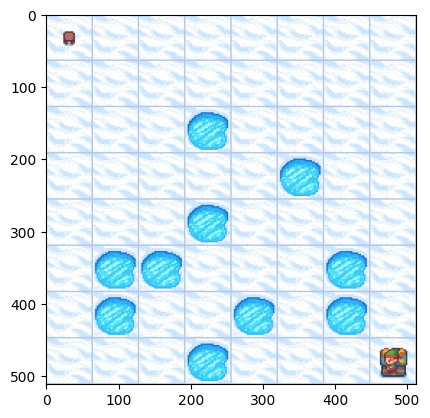

In [420]:
a = Pi[s]
s, r, terminated, truncated, _ = env.step(a)
rgb = env.render()
plt.imshow(rgb)

In [ ]:
# Experiments
# Compare: 
# * slippery True vs False
# * gamma=0.001, gamma=1
# Total number of iterations
# Measure total of state values as gamma changes
# Measure total n differences in policy from gamma-i to gamma-i+1
# Simulate and get total rewards (average over 100 or 1000 simulations)

In [ ]:
# TODO Create a general way to convert from an observation
# space to an integer map
# Then use this to convert the observation to state

In [625]:
# get blackjack
def get_s_blackjack(env):
    # https://stackoverflow.com/questions/7367770/how-to-flatten-or-index-3d-array-in-1d-array
    x, y, z = tuple(int(v) for v in env.unwrapped._get_obs())
    x_dim, y_dim, z_dim = tuple(int(v.n) for v in env.observation_space)
    # https://coderwall.com/p/fzni3g/bidirectional-translation-between-1d-and-3d-arrays
    i = x + y * x_dim + z * x_dim * y_dim
    return i

# set blackjack
def set_s_blackjack(env, s):
    # Returns True is valid state, or False if not (if False, state was not set)
    from gymnasium.envs.toy_text.blackjack import draw_card, draw_hand, sum_hand, usable_ace
    # relevant source code from here:
    # https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/blackjack.py
    # This function must work exactly like the source code under the hood
    # TODO reverse the index calculation, set result to new_state
    # https://coderwall.com/p/fzni3g/bidirectional-translation-between-1d-and-3d-arrays
    # https://stackoverflow.com/questions/11316490/convert-a-1d-array-index-to-a-3d-array-index
    x_dim, y_dim, z_dim = tuple(int(v.n) for v in env.observation_space)
    x, y, z = (
        s % x_dim,
        (s // x_dim) % y_dim,
        s // (x_dim * y_dim)
    )
    # new_state = (0, 0, 0)
    # env.unwrapped.player = [0, new_state[0]]
    player = draw_hand(np.random)
    i = 0
    while (sum_hand(player) != x) or (usable_ace(player) != z):
        player = draw_hand(np.random)
        i += 1
        if i > 10000:
            return False
    env.unwrapped.player = player
    # Set dealer hand
    env.unwrapped.dealer = [
        y, 
        draw_card(np.random)
        ]
    return True

def get_s_size_blackjack(env):
    return 32 * 11 * 2

In [740]:
def get_blackjack_win_ratio(env, Pi):
    np.random.seed(42)
    results = list()
    for _ in range(100000):
        env.reset()
        terminated = False
        while not terminated:
            a = Pi[get_s_blackjack(env)]
            s, r, terminated, truncated, _ = env.step(a)
        results.append(r)
    win_ratio = (np.array(results) == 1).mean()
    print("win ratio:", win_ratio)
    return win_ratio

In [744]:
%%time 

env = gymnasium.make(
    'Blackjack-v1',
    render_mode="rgb_array"
    )
P, R, V, Pi = policy_iteration(env, set_s_blackjack, get_s_size_blackjack(env), 
    gamma=1.0, max_delta = 0.1, max_iter = 10, sample_size=10)
win_ratio = get_blackjack_win_ratio(env, Pi)

iterations:  5
win ratio: 0.35144
CPU times: user 1min 15s, sys: 688 ms, total: 1min 15s
Wall time: 1min 15s


In [746]:
%%time 

env = gymnasium.make(
    'Blackjack-v1',
    render_mode="rgb_array"
    )
P, R, V, Pi = policy_iteration(env, set_s_blackjack, get_s_size_blackjack(env), 
    gamma=1.0, max_delta = 0.01, max_iter = 100, sample_size=100)
win_ratio = get_blackjack_win_ratio(env, Pi)

iterations:  5
win ratio: 0.36184
CPU times: user 1min 39s, sys: 1.05 s, total: 1min 41s
Wall time: 1min 40s


In [747]:
%%time 

env = gymnasium.make(
    'Blackjack-v1',
    render_mode="rgb_array"
    )
P, R, V, Pi = policy_iteration(env, set_s_blackjack, get_s_size_blackjack(env), 
    gamma=1.0, max_delta = 0.001, max_iter = 1000, sample_size=1000)
win_ratio = get_blackjack_win_ratio(env, Pi)

iterations:  9
win ratio: 0.36483
CPU times: user 6min 1s, sys: 3.54 s, total: 6min 5s
Wall time: 6min 1s


In [748]:
%%time 

env = gymnasium.make(
    'Blackjack-v1',
    render_mode="rgb_array"
    )
P, R, V, Pi = policy_iteration(env, set_s_blackjack, get_s_size_blackjack(env), 
    gamma=1.0, max_delta = 0.01, max_iter = 1000, sample_size=1000)
win_ratio = get_blackjack_win_ratio(env, Pi)

iterations:  7
win ratio: 0.34983
CPU times: user 5min 59s, sys: 3.63 s, total: 6min 3s
Wall time: 6min


In [749]:
%%time 

env = gymnasium.make(
    'Blackjack-v1',
    render_mode="rgb_array"
    )
P, R, V, Pi = policy_iteration(env, set_s_blackjack, get_s_size_blackjack(env), 
    gamma=1.0, max_delta = 0.001, max_iter = 1000, sample_size=100)
win_ratio = get_blackjack_win_ratio(env, Pi)

iterations:  4
win ratio: 0.33987
CPU times: user 1min 41s, sys: 1.04 s, total: 1min 42s
Wall time: 1min 41s


In [751]:
%%time 

env = gymnasium.make(
    'Blackjack-v1',
    render_mode="rgb_array"
    )
P, R, V, Pi = policy_iteration(env, set_s_blackjack, get_s_size_blackjack(env), 
    gamma=1.0, max_delta = 0.0001, max_iter = 1000, sample_size=100)
win_ratio = get_blackjack_win_ratio(env, Pi)

iterations:  5
win ratio: 0.34972
CPU times: user 1min 43s, sys: 1.34 s, total: 1min 45s
Wall time: 1min 44s


* Found the odds of winning are 42.22%, so I want to get as close to this as possible
* Source: https://www.onlinegambling.com/blackjack/odds/

* After adjustments, the policy improved as more iterations were allowed, this was controlled by reducing the max delta parameter in the policy iteration algorithm
* However, the runtime has increased to 6 minutes to compute the policy. Adjusting to run the sampling in the transition matrix to run in parallel (any other opportunities? speed profile?)

Tested blackjack-policy iteration with max_delta=.1 and max_iter=10, sample_size=10 and it learned a bad policy but took less time. It chose not to hit on a 4 
TODO run experiment with various settings and compute win rate
* gamma=1.0, max_delta = 0.1, max_iter = 10, sample_size=10 
    * iterations:  3
    * win ratio: 0.319
    * CPU times: user 1min 11s, sys: 754 ms, total: 1min 12s
    * Wall time: 1min 11s
* gamma=1.0, max_delta = 0.01, max_iter = 100, sample_size=100
* gamma=1.0, max_delta = 0.001, max_iter = 1000, sample_size=1000

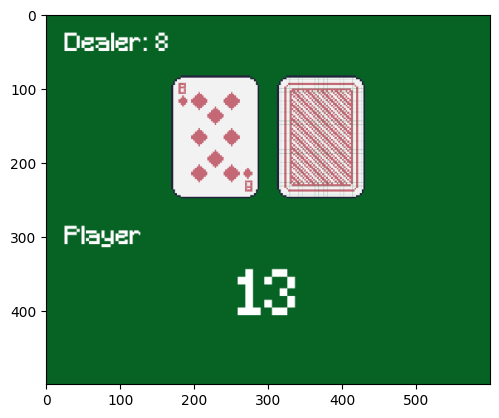

In [660]:
env.reset()
rgb = env.render()
plt.imshow(rgb)

hit:  0
Done:   reward:  -1.0


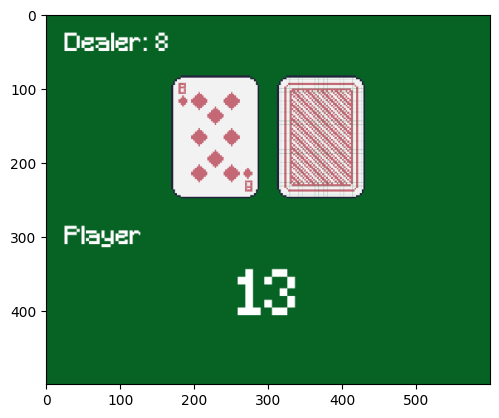

In [661]:
a = Pi[get_s_blackjack(env)]
print("hit: ", a)
s, r, terminated, truncated, _ = env.step(a)
if terminated:
    print("Done: ", " reward: ", r)
rgb = env.render()
plt.imshow(rgb)

In [777]:
from time import perf_counter

# Value Iteration

env = gymnasium.make(
    'Blackjack-v1',
    render_mode="rgb_array"
    )
set_s = set_s_blackjack
n_states = get_s_size_blackjack(env)
gamma=1.0
max_delta = 0.00001
max_iter = 100
sample_size=100

def value_iteration(env, set_s: Callable, n_states, 
    gamma=1.0, max_delta = 0.00001, max_iter = 100, sample_size=100, P=None, R=None):

    start = perf_counter()
    if P is None or R is None:
        P, R = get_P_and_R(env, n_states, sample_size, set_s)
    stop = perf_counter()
    print("get_P_and_R, %.4f seconds" % (stop-start))

    # Initialization
    V = np.zeros(shape=(n_states, ), dtype=np.float32)
    Pi = np.zeros(shape=(n_states, ), dtype=np.int32)

    # Policy Evaluation
    delta = np.inf
    i = 0
    while delta > max_delta:
        delta = 0
        for s in range(n_states):
            v = V[s]
            V[s] = np.max([np.sum(P[s, a, :] * (R[s, a, :] + gamma * V)) 
                for a in range(env.action_space.n)])
            delta = max(delta, abs(v - V[s]))
        if i>=max_iter:
            print("max iterations reached...")
            break
        i+=1
    print("iterations: ", i)
    # Compute policy
    for s in range(n_states):
        b = Pi[s]
        V_discounted = gamma * V
        Pi[s] = np.argmax([sum(P[s, a, :] * (R[s, a, :] + V_discounted))
            for a in range(env.action_space.n)])
    return P, R, V, Pi

In [774]:
%%time 

env = gymnasium.make(
    'Blackjack-v1',
    render_mode="rgb_array"
    )
P, R, V, Pi = value_iteration(env, set_s_blackjack, get_s_size_blackjack(env), 
    gamma=1.0, max_delta = 0.001, max_iter = 1000, sample_size=1000)
win_ratio = get_blackjack_win_ratio(env, Pi)

get_P_and_R, 351.1002 seconds
max iterations reached...
iterations:  1001
win ratio: 0.36528
CPU times: user 6min 2s, sys: 2.92 s, total: 6min 5s
Wall time: 6min 2s


In [776]:
%%time

P, R, V, Pi = value_iteration(env, set_s_blackjack, get_s_size_blackjack(env), 
    gamma=1.0, max_delta = 0.001, max_iter = 10000, sample_size=None, P=P, R=R)
win_ratio = get_blackjack_win_ratio(env, Pi)

get_P_and_R, 0.0000 seconds
max iterations reached...
iterations:  10001
win ratio: 0.3613
CPU times: user 1min 17s, sys: 701 ms, total: 1min 18s
Wall time: 1min 17s


In [778]:
%%time

P, R, V, Pi = value_iteration(env, set_s_blackjack, get_s_size_blackjack(env), 
    gamma=1.0, max_delta = 0.001, max_iter = 100000, sample_size=None, P=P, R=R)
win_ratio = get_blackjack_win_ratio(env, Pi)

get_P_and_R, 0.0000 seconds
max iterations reached...
iterations:  100000
win ratio: 0.36133
CPU times: user 12min 15s, sys: 6.1 s, total: 12min 21s
Wall time: 12min 14s


In [ ]:
# Q-Learning